<a href="https://colab.research.google.com/github/atahanoezer/Wind/blob/main/Notebooks/UEBB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
!pip install catboost

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime
from sklearn.metrics import mean_absolute_percentage_error
from catboost import CatBoostRegressor

In [ ]:
! git clone https://github.com/atahanoezer/Wind.git

In [8]:
from Wind.dataset import Dataset
from Wind.utils import experiment_results
from Wind.model import *

In [3]:
import warnings
warnings.filterwarnings('ignore') # to avoid catboost and pd warnings

# Data Preprocess

In [4]:
uebb = 'datasets/Brazil/UEBB_v1.nc'
ds = xr.open_dataset(uebb)
df = ds.to_dataframe()
df =df.loc[(df.index.get_level_values('Turbine') == 1.0) & (df.index.get_level_values('Height') == 60.0)]
df = df.reset_index()
df['Time']=pd.to_datetime(df['Time'])
df = df.set_index('Time')

In [5]:
test_time = pd.to_datetime('2014-05-18 18:50:00')
df_test = df[df.index >= test_time]
test_split = len(df_test)/len(df)

Following fields are observed via pandas profiling, reports can be generated by running the profiler function in utils.py

In [6]:
high_empty_fields = ['wind_direction_std','air_temperature','relative_humidity', 'UST','UST_flag', 'HS','HS_flag', 'TKE',
                     'LMO','ws_w_corrected'] #
missing_fields = ['wind_speed','wind_direction','wind_speed_std','wind_speed_max','wind_speed_min',
                         'wind_speed_cube','air_pressure','logger_temperature', 'battery_V','ws_u','ws_v','ws_w',
                         'tilt_X','tilt_Y','tilt_X_std','tilt_Y_std','wind_speed_nacelle','wind_speed_nacelle_max',
                         'wind_speed_nacelle_min','rotor_rpm','rotor_rpm_max','rotor_rpm_min','active_power_total',
                         'active_power_total_max','active_power_total_min','act_position','air_density']

In [9]:
roll_window = 4
dataset = Dataset(df)
dataset.fill_nan(missing_fields)
dataset.drop_nan(high_empty_fields)
dataset.add_seasonal_feat(dataset.df, dataset.df.index)
dataset.apply_rolling_window(dataset.df,'wind_speed', roll_window,np.mean)
dataset.apply_rolling_window(dataset.df,'air_pressure', roll_window,np.mean)
dataset.apply_rolling_window(dataset.df,'rotor_rpm', roll_window,np.mean)
dataset.apply_rolling_window(dataset.df,'wind_speed_nacelle', roll_window,np.mean)

# One-Shot Modelling



## Next Step Prediction



### Default

In [17]:
window = 48
horizon =1
train_x,val_x, test_x, train_y,val_y, test_y,columns =dataset.create_dataset(dataset.df,
                                                                     window, horizon,test_split = test_split,univariate = False
                                                                     ,val_split = 0.1)

In [18]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU"})
model.train(train_x, train_y, val_x, val_y)

Learning rate set to 0.091607
0:	learn: 212.2191126	test: 241.4391529	best: 241.4391529 (0)	total: 11.7ms	remaining: 11.6s
500:	learn: 44.7534817	test: 35.9710254	best: 35.9323563 (478)	total: 4.8s	remaining: 4.78s
999:	learn: 42.6539719	test: 36.1520892	best: 35.9323563 (478)	total: 9.31s	remaining: 0us
bestTest = 35.93235628
bestIteration = 478
Shrink model to first 479 iterations.


                  MAE       RMSE        R2
Validation  21.332994  35.932356  0.919593
Test        34.104791  52.417465  0.937889


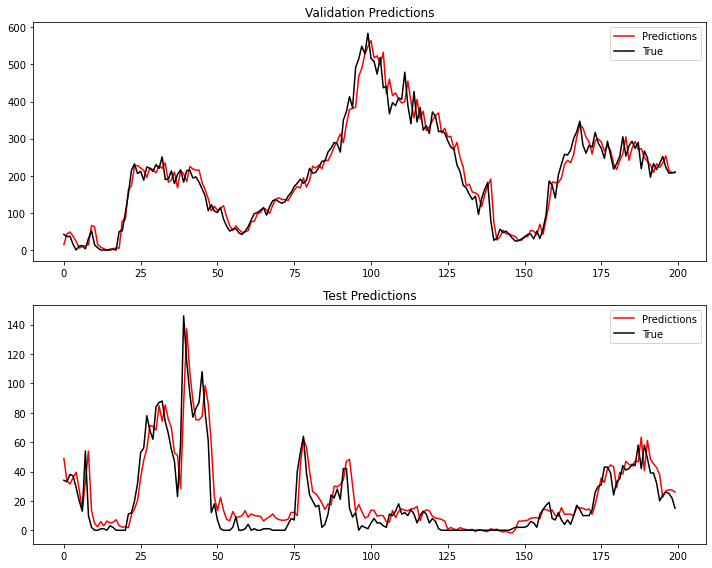

In [19]:
next_step_os,_=model.model_summarizer(val_x, val_y, test_x, test_y, plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names=columns)

### Feat Select

In [20]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU"})
feats = model.feat_select(val_x = val_x, val_y = val_y, train_x = train_x, train_y= train_y,num_feats =40,plot= False)
train_x,val_x,test_x = train_x[:,feats['selected_features']],val_x[:,feats['selected_features']],test_x[:,feats['selected_features']]

In [21]:
model.train(train_x, train_y, val_x, val_y)

Learning rate set to 0.091607
0:	learn: 212.2912428	test: 241.2467869	best: 241.2467869 (0)	total: 8.75ms	remaining: 8.74s
500:	learn: 45.0243392	test: 35.8813526	best: 35.8809655 (498)	total: 4.24s	remaining: 4.22s
999:	learn: 42.8727244	test: 35.6342724	best: 35.6332339 (997)	total: 8.46s	remaining: 0us
bestTest = 35.63323391
bestIteration = 997
Shrink model to first 998 iterations.


                  MAE       RMSE        R2
Validation  21.230917  35.633232  0.920926
Test        34.230316  53.139840  0.936165


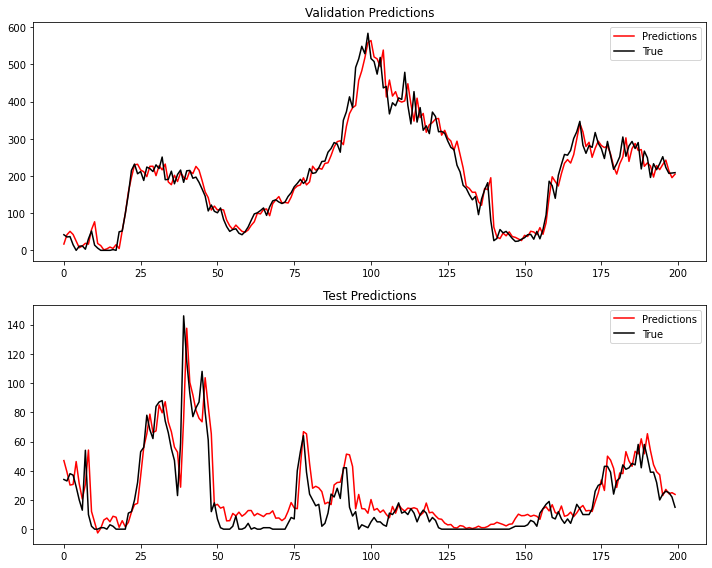

In [22]:
next_step_os_feat,_=model.model_summarizer(val_x, val_y, test_x, test_y, plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names=columns)

### Hyp-op

In [23]:
model.hyp_op(val_x = val_x, val_y = val_y, train_x = train_x, train_y= train_y, task_type = 'GPU')

[I 2023-09-03 12:25:14,331] A new study created in memory with name: no-name-60156c50-b88e-4c06-ba43-d007a9a3d983
[I 2023-09-03 12:25:26,129] Trial 0 finished with value: 21.39858111796859 and parameters: {'learning_rate': 0.01668406208290246, 'depth': 7, 'min_data_in_leaf': 75}. Best is trial 0 with value: 21.39858111796859.
[I 2023-09-03 12:25:50,963] Trial 1 finished with value: 21.35698180794438 and parameters: {'learning_rate': 0.018860338379004648, 'depth': 9, 'min_data_in_leaf': 20}. Best is trial 1 with value: 21.35698180794438.
[I 2023-09-03 12:26:30,343] Trial 2 finished with value: 21.37763287414119 and parameters: {'learning_rate': 0.019072566425173933, 'depth': 10, 'min_data_in_leaf': 71}. Best is trial 1 with value: 21.35698180794438.
[I 2023-09-03 12:27:13,794] Trial 3 finished with value: 21.48346838263525 and parameters: {'learning_rate': 0.011636985046744422, 'depth': 10, 'min_data_in_leaf': 22}. Best is trial 1 with value: 21.35698180794438.
[I 2023-09-03 12:27:18,79

Best hyperparameters: {'learning_rate': 0.062127560324348796, 'depth': 7, 'min_data_in_leaf': 53}
Best RMSE: 21.071976208783784


({'learning_rate': 0.062127560324348796, 'depth': 7, 'min_data_in_leaf': 53},
 21.071976208783784)

                  MAE       RMSE        R2
Validation  21.310591  36.248392  0.918173
Test        33.552528  51.984362  0.938911


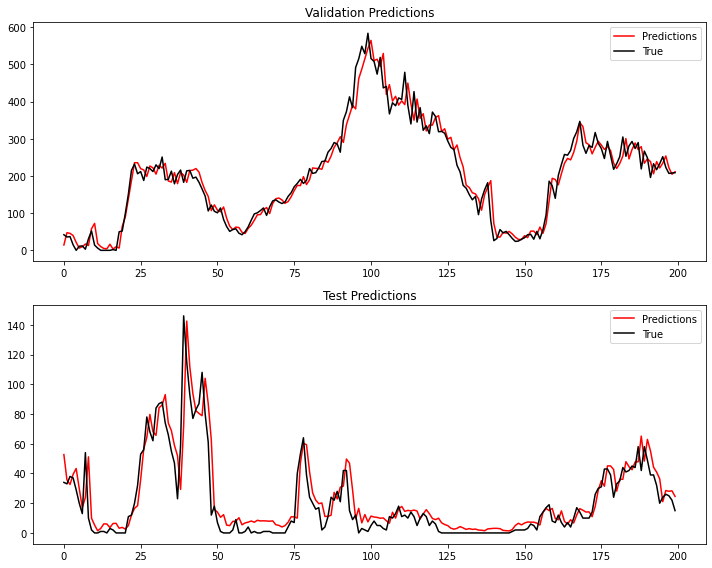

In [24]:
next_step_os_feat_hy,_=model.model_summarizer(val_x, val_y, test_x, test_y, plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names=columns)

### Hyp-op Transfer

In [25]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU",'learning_rate': 0.060056213534812046, 'depth': 9, 'min_data_in_leaf': 64})
model.train(train_x, train_y, val_x, val_y)

0:	learn: 218.6807596	test: 249.0489796	best: 249.0489796 (0)	total: 31.8ms	remaining: 31.7s
500:	learn: 44.6034726	test: 36.0331043	best: 36.0147566 (487)	total: 13.1s	remaining: 13s
999:	learn: 42.0469456	test: 35.6587829	best: 35.6580506 (997)	total: 27.3s	remaining: 0us
bestTest = 35.65805064
bestIteration = 997
Shrink model to first 998 iterations.


                  MAE       RMSE        R2
Validation  21.107481  35.658050  0.920816
Test        33.586327  52.013726  0.938842


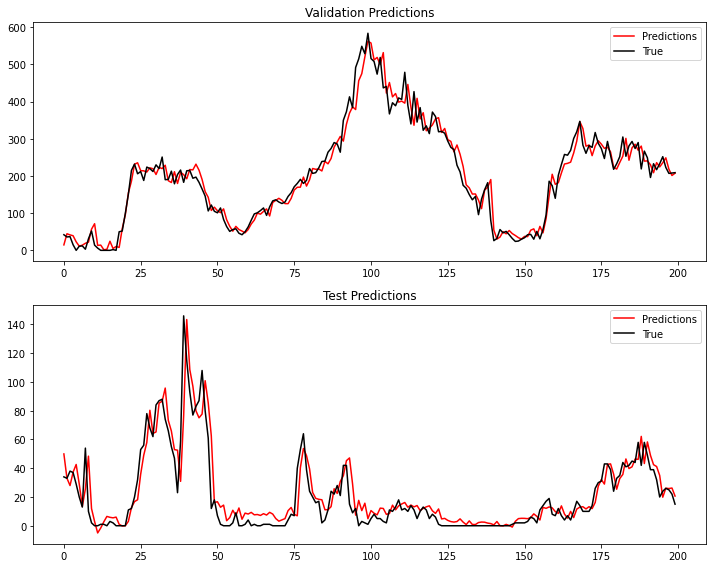

In [26]:
next_step_os_feat,_=model.model_summarizer(val_x, val_y, test_x, test_y, plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names=columns)

In [27]:
train_x.shape,val_x.shape

((36569, 40), (5256, 40))



## Next Hour Prediction



### Default

In [30]:
window = 48
horizon = 6
train_x,val_x, test_x, train_y,val_y, test_y, columns =dataset.create_dataset(dataset.df,
                                                                     window, horizon,test_split = test_split,val_split = 0.1)

In [32]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU"})
model.train(train_x, train_y[:,-1], val_x, val_y[:,-1],multioutput=False)

Learning rate set to 0.091606
0:	learn: 216.3626917	test: 244.1634301	best: 244.1634301 (0)	total: 11.5ms	remaining: 11.5s
500:	learn: 84.3092826	test: 70.7783965	best: 70.6920385 (445)	total: 5.24s	remaining: 5.22s
999:	learn: 77.5455105	test: 71.4833875	best: 70.6920385 (445)	total: 10.2s	remaining: 0us
bestTest = 70.69203853
bestIteration = 445
Shrink model to first 446 iterations.


                  MAE        RMSE        R2
Validation  48.274549   70.692043  0.688824
Test        77.657147  110.062458  0.726131


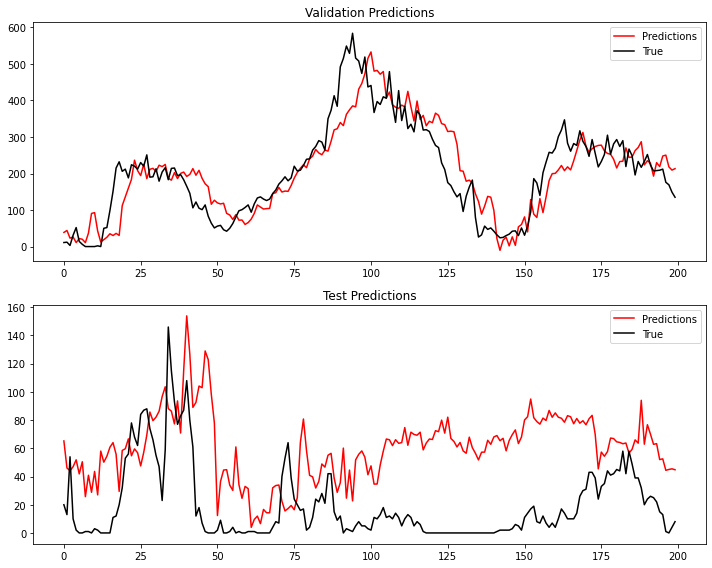

In [33]:
next_hour_os,_=model.model_summarizer(val_x, val_y[:,-1], test_x, test_y[:,-1], plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names= columns)

### Feat Select

In [34]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU"})
feats = model.feat_select(val_x = val_x, val_y = val_y[:,-1], train_x = train_x, train_y= train_y[:,-1],num_feats =40,plot= False)
train_x,val_x,test_x = train_x[:,feats['selected_features']],val_x[:,feats['selected_features']],test_x[:,feats['selected_features']]


In [35]:
model.train(train_x, train_y[:,-1], val_x, val_y[:,-1])

Learning rate set to 0.091606
0:	learn: 216.2065647	test: 244.1952757	best: 244.1952757 (0)	total: 8.95ms	remaining: 8.94s
500:	learn: 85.7349546	test: 71.2770525	best: 70.9253472 (430)	total: 4.28s	remaining: 4.26s
999:	learn: 79.5468184	test: 72.4652518	best: 70.9077094 (701)	total: 8.5s	remaining: 0us
bestTest = 70.90770943
bestIteration = 701
Shrink model to first 702 iterations.


                  MAE        RMSE        R2
Validation  48.178184   70.907705  0.686922
Test        78.250055  109.291281  0.729955


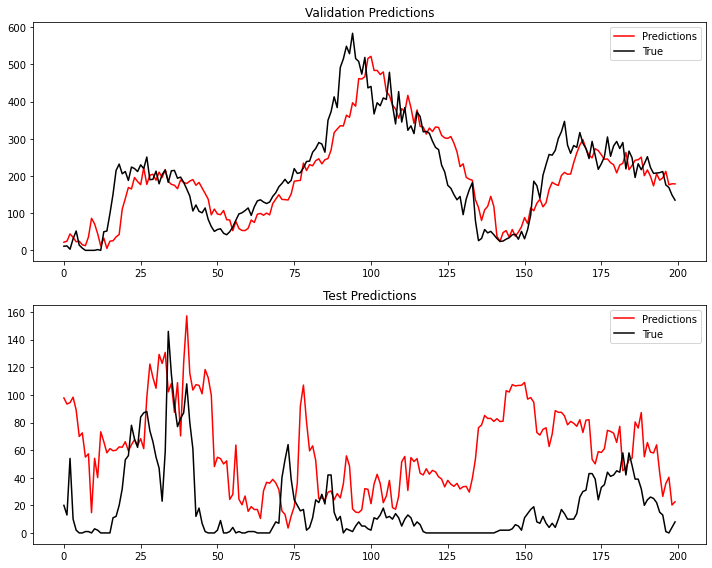

In [36]:
next_hour_os_feat,_=model.model_summarizer(val_x, val_y[:,-1], test_x, test_y[:,-1], plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names= columns)

### Hyp-op

In [37]:
model.hyp_op(val_x = val_x, val_y = val_y[:,-1], train_x = train_x, train_y= train_y[:,-1])

[I 2023-09-03 12:37:14,685] A new study created in memory with name: no-name-6167be15-219f-44c6-8770-7b248a7709ac
[I 2023-09-03 12:37:23,622] Trial 0 finished with value: 47.17229329168753 and parameters: {'learning_rate': 0.04752055838935766, 'depth': 6, 'min_data_in_leaf': 22}. Best is trial 0 with value: 47.17229329168753.
[I 2023-09-03 12:37:29,546] Trial 1 finished with value: 51.31630916752108 and parameters: {'learning_rate': 0.00611418950192022, 'depth': 4, 'min_data_in_leaf': 12}. Best is trial 0 with value: 47.17229329168753.
[I 2023-09-03 12:37:59,279] Trial 2 finished with value: 48.61099081725454 and parameters: {'learning_rate': 0.06290338998141838, 'depth': 9, 'min_data_in_leaf': 61}. Best is trial 0 with value: 47.17229329168753.
[I 2023-09-03 12:38:05,191] Trial 3 finished with value: 88.7473668992907 and parameters: {'learning_rate': 0.0016887339784910325, 'depth': 4, 'min_data_in_leaf': 23}. Best is trial 0 with value: 47.17229329168753.
[I 2023-09-03 12:38:09,663] T

Best hyperparameters: {'learning_rate': 0.027775365748985033, 'depth': 8, 'min_data_in_leaf': 92}
Best RMSE: 46.45095028832678


({'learning_rate': 0.027775365748985033, 'depth': 8, 'min_data_in_leaf': 92},
 46.45095028832678)

                  MAE        RMSE        R2
Validation  46.500832   69.894514  0.695805
Test        77.141366  108.761683  0.732566


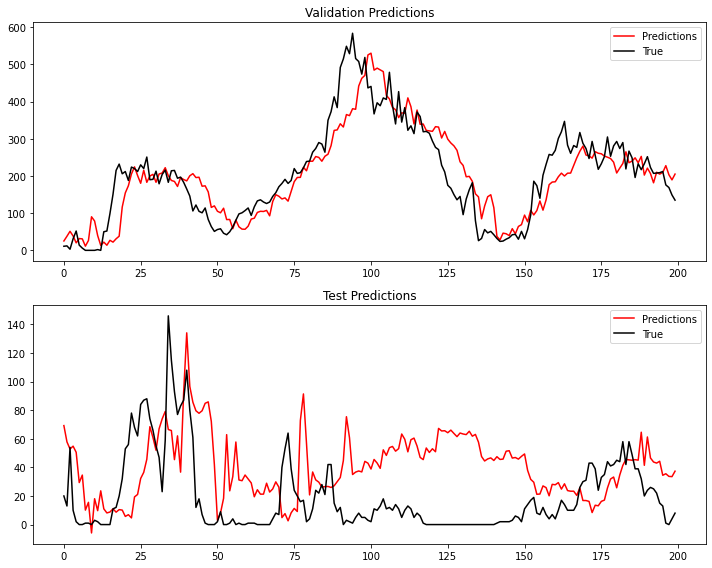

In [38]:
next_hour_os_feat_hy,_=model.model_summarizer(val_x, val_y[:,-1], test_x, test_y[:,-1], plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names= columns)

### Hyp-op Transfer

In [39]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU",'learning_rate': 0.01295853204616923, 'depth': 6, 'min_data_in_leaf': 70})
model.train(train_x, train_y[:,-1], val_x, val_y[:,-1],multioutput=False)

0:	learn: 229.2081869	test: 261.0591672	best: 261.0591672 (0)	total: 10.5ms	remaining: 10.4s
500:	learn: 98.2332453	test: 71.9492881	best: 71.9492881 (500)	total: 4.43s	remaining: 4.41s
999:	learn: 94.4733338	test: 70.8829936	best: 70.8594597 (973)	total: 8.81s	remaining: 0us
bestTest = 70.85945975
bestIteration = 973
Shrink model to first 974 iterations.


                  MAE        RMSE        R2
Validation  47.577800   70.859462  0.687348
Test        75.640324  106.668113  0.742763


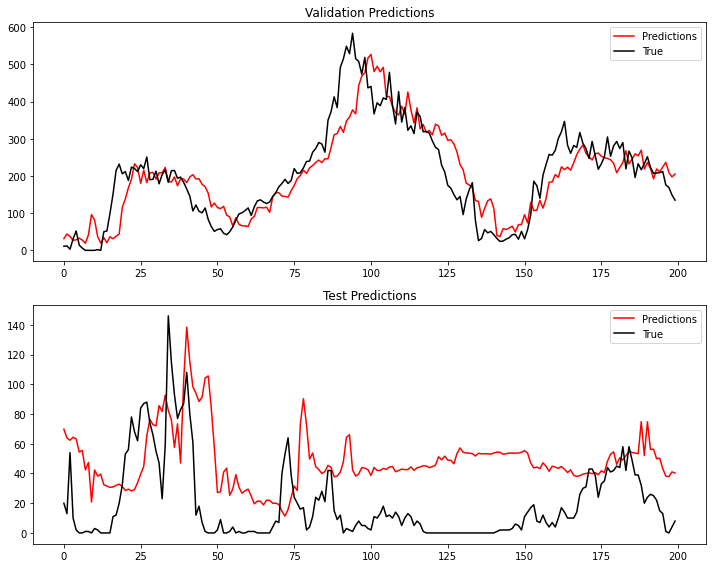

In [40]:
next_hour_os,_=model.model_summarizer(val_x, val_y[:,-1], test_x, test_y[:,-1], plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names= columns)

## Next Day Prediction

### Default

In [42]:
window = 144
horizon = 144
train_x,val_x, test_x, train_y,val_y, test_y,columns =dataset.create_dataset(dataset.df,
                                                                     window, horizon,test_split= test_split,val_split=0.1)

In [43]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU"})
model.train(train_x, train_y[:,-1], val_x, val_y[:,-1],multioutput=False)

Learning rate set to 0.091542
0:	learn: 221.8305069	test: 253.8753265	best: 253.8753265 (0)	total: 14.8ms	remaining: 14.8s
500:	learn: 105.2021357	test: 121.7485297	best: 121.1725554 (493)	total: 6.39s	remaining: 6.37s
999:	learn: 87.4341087	test: 120.1974320	best: 118.2237467 (826)	total: 12.6s	remaining: 0us
bestTest = 118.2237467
bestIteration = 826
Shrink model to first 827 iterations.


                   MAE        RMSE        R2
Validation   90.186445  118.223766  0.116899
Test        149.102038  186.474719  0.209482


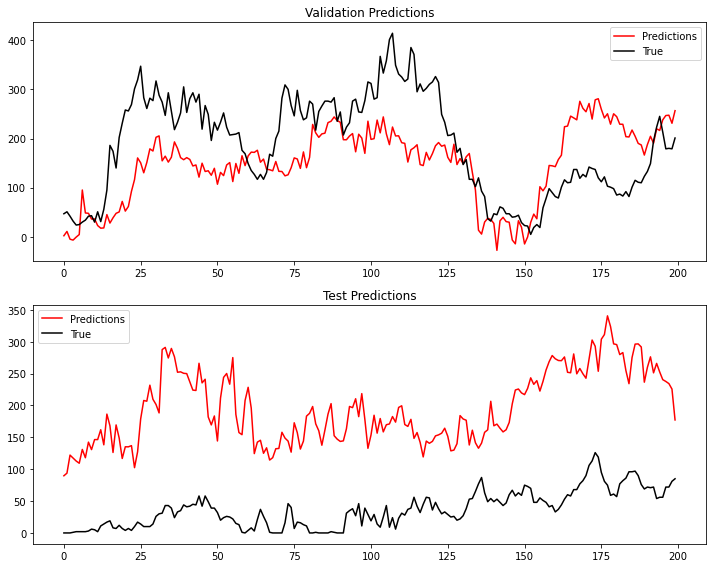

In [44]:
next_day_os,_=model.model_summarizer(val_x, val_y[:,-1], test_x, test_y[:,-1], plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names= columns)

### Feat Select

In [45]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU"})

feats = model.feat_select(val_x = val_x, val_y = val_y[:,-1], train_x = train_x, train_y= train_y[:,-1],num_feats =40,plot= False)
train_x,val_x,test_x = train_x[:,feats['selected_features']],val_x[:,feats['selected_features']],test_x[:,feats['selected_features']]

In [46]:
model.train(train_x, train_y[:,-1], val_x, val_y[:,-1],multioutput=False)

Learning rate set to 0.091542
0:	learn: 221.9285924	test: 254.1546782	best: 254.1546782 (0)	total: 9.29ms	remaining: 9.28s
500:	learn: 115.1767746	test: 114.7859205	best: 111.3839965 (271)	total: 4.4s	remaining: 4.38s
999:	learn: 101.2583248	test: 122.5900548	best: 111.3839965 (271)	total: 8.71s	remaining: 0us
bestTest = 111.3839965
bestIteration = 271
Shrink model to first 272 iterations.


                   MAE        RMSE        R2
Validation   84.305465  111.383990  0.216126
Test        152.185923  186.464016  0.209573


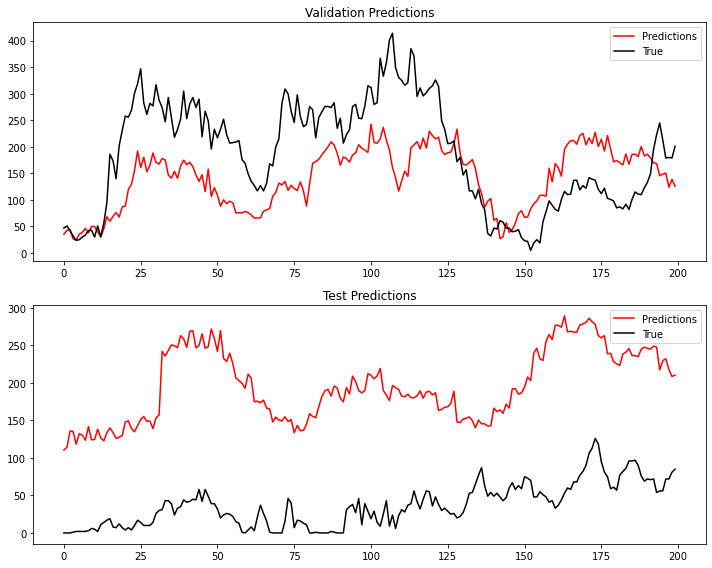

In [47]:
next_day_os_feat,_=model.model_summarizer(val_x, val_y[:,-1], test_x, test_y[:,-1], plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names= columns)

### Hyp-op

In [48]:
model.hyp_op(val_x = val_x, val_y = val_y[:,-1], train_x = train_x, train_y= train_y[:,-1])

[I 2023-09-03 12:48:45,173] A new study created in memory with name: no-name-321f20e4-da7d-4a08-834b-1322c8d31993
[I 2023-09-03 12:48:57,838] Trial 0 finished with value: 106.54322226110955 and parameters: {'learning_rate': 0.006932754087245606, 'depth': 7, 'min_data_in_leaf': 6}. Best is trial 0 with value: 106.54322226110955.
[I 2023-09-03 12:49:02,097] Trial 1 finished with value: 160.15242960990938 and parameters: {'learning_rate': 0.002261797878521885, 'depth': 1, 'min_data_in_leaf': 26}. Best is trial 0 with value: 106.54322226110955.
[I 2023-09-03 12:49:09,314] Trial 2 finished with value: 80.88529775077167 and parameters: {'learning_rate': 0.039985116336994184, 'depth': 5, 'min_data_in_leaf': 97}. Best is trial 2 with value: 80.88529775077167.
[I 2023-09-03 12:49:42,396] Trial 3 finished with value: 117.09329562664462 and parameters: {'learning_rate': 0.004988210429776587, 'depth': 9, 'min_data_in_leaf': 95}. Best is trial 2 with value: 80.88529775077167.
[I 2023-09-03 12:49:46

Best hyperparameters: {'learning_rate': 0.05428173844870543, 'depth': 6, 'min_data_in_leaf': 2}
Best RMSE: 80.48448546946678


({'learning_rate': 0.05428173844870543, 'depth': 6, 'min_data_in_leaf': 2},
 80.48448546946678)

                   MAE        RMSE       R2
Validation   91.982725  117.581368  0.12647
Test        153.475440  185.942227  0.21399


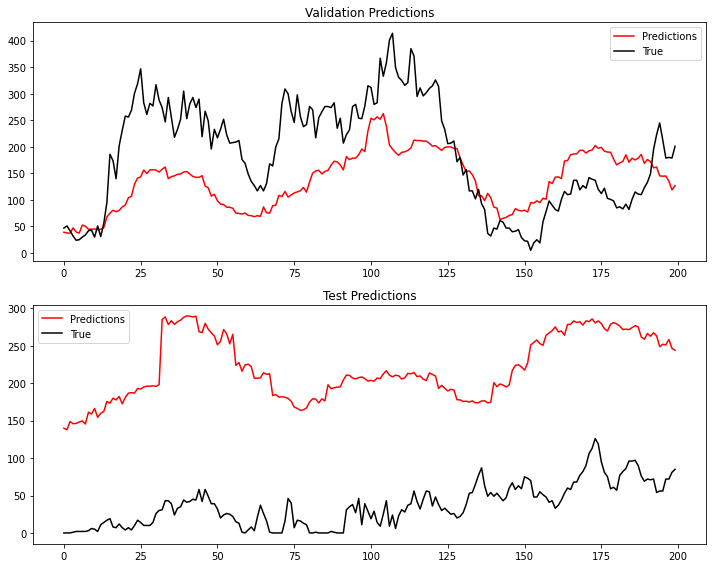

In [50]:
next_day_os_feat_hy,_=model.model_summarizer(val_x, val_y[:,-1], test_x, test_y[:,-1], plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names= columns)

### Hyp-op Transfer

In [51]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU",'learning_rate': 0.0289836229349701, 'depth': 2, 'min_data_in_leaf': 62})
model.train(train_x, train_y[:,-1], val_x, val_y[:,-1],multioutput=False)

0:	learn: 229.0995243	test: 262.6345333	best: 262.6345333 (0)	total: 5.48ms	remaining: 5.47s
500:	learn: 160.9884196	test: 131.2882506	best: 129.7115909 (199)	total: 2.01s	remaining: 2s
999:	learn: 156.7589884	test: 127.7263234	best: 127.4246432 (971)	total: 4.01s	remaining: 0us
bestTest = 127.4246432
bestIteration = 971
Shrink model to first 972 iterations.


                   MAE        RMSE        R2
Validation  102.699962  127.424644 -0.025906
Test        150.596034  185.414252  0.218448


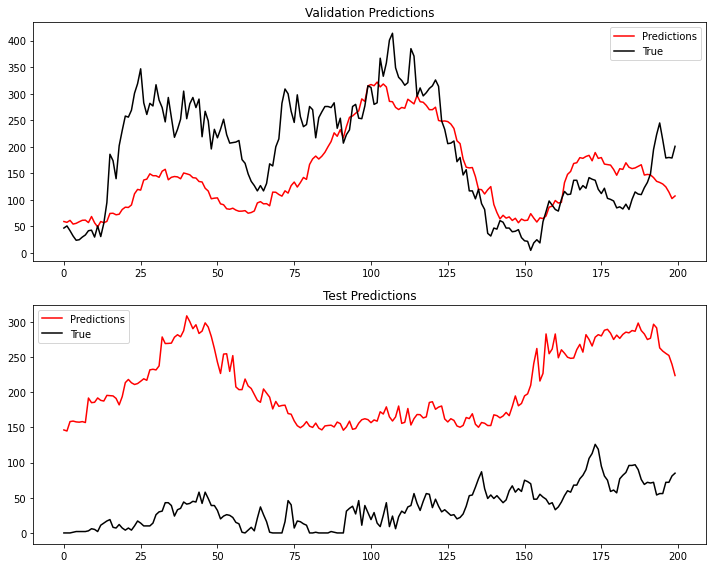

In [52]:
next_day_os,_=model.model_summarizer(val_x, val_y[:,-1], test_x, test_y[:,-1], plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names= columns)

# Recursive Modelling

## Next Hour 

### Default Recursive

In [53]:
window = 48
horizon = 6
train_x,val_x, test_x, train_y,val_y, test_y,columns =dataset.create_dataset(dataset.df,
                                                                     window, horizon,test_split = test_split,univariate= True,val_split=0.1)

In [54]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU"},prediction_type = 'recursive')
model.train(train_x, train_y[:,0], val_x, val_y[:,0],multioutput=False)

Learning rate set to 0.091606
0:	learn: 212.4690347	test: 241.0548013	best: 241.0548013 (0)	total: 9.98ms	remaining: 9.97s
500:	learn: 53.9880683	test: 39.5907964	best: 39.5526824 (477)	total: 4.08s	remaining: 4.06s
999:	learn: 51.9025178	test: 39.6462252	best: 39.5526824 (477)	total: 7.91s	remaining: 0us
bestTest = 39.55268237
bestIteration = 477
Shrink model to first 478 iterations.


                  MAE       RMSE        R2
Validation  29.973624  45.626716  0.870392
Test        49.411526  71.510847  0.884390


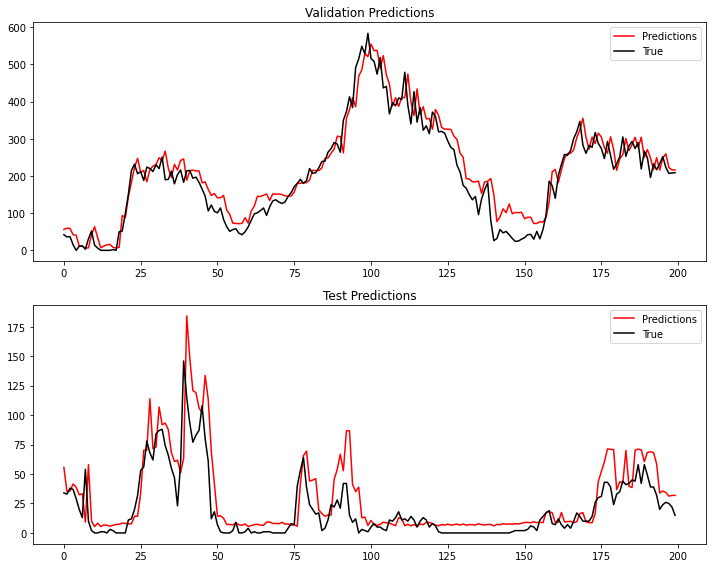

In [55]:
next_hour_rec,_=model.model_summarizer(val_x, val_y[:,0], test_x, test_y[:,0], plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names= columns,horizon =6)

### Recursive with Transferred Hyp-op

In [56]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU",'learning_rate': 0.060056213534812046, 'depth': 9, 'min_data_in_leaf': 64},prediction_type = 'recursive')
model.train(train_x, train_y[:,0], val_x, val_y[:,0],multioutput=False)

0:	learn: 218.6752048	test: 248.8400759	best: 248.8400759 (0)	total: 36.9ms	remaining: 36.9s


500:	learn: 53.0566963	test: 39.5246717	best: 39.5155461 (490)	total: 13.3s	remaining: 13.3s
999:	learn: 50.6247113	test: 39.5368323	best: 39.5028764 (539)	total: 25.5s	remaining: 0us
bestTest = 39.50287638
bestIteration = 539
Shrink model to first 540 iterations.


                  MAE       RMSE        R2
Validation  30.906827  46.311693  0.866471
Test        50.600276  72.057299  0.882617


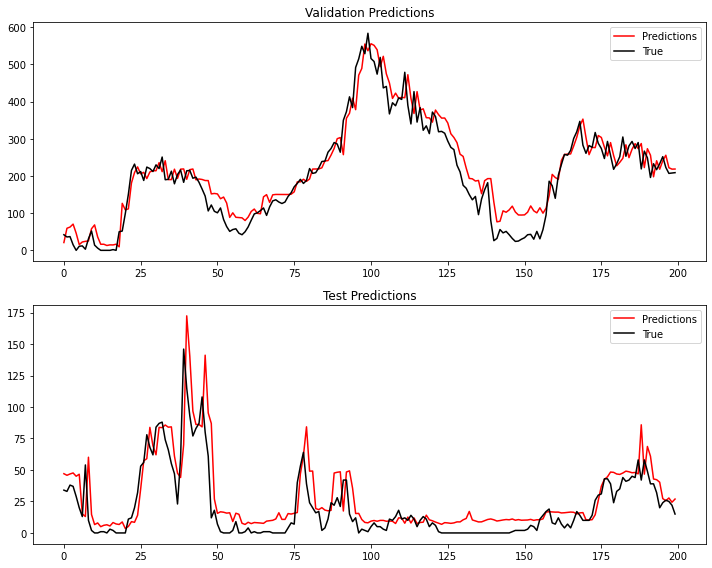

In [57]:
next_hour_rec,_=model.model_summarizer(val_x, val_y[:,0], test_x, test_y[:,0], plots=True,
plot_steps=200, feat_importance=False, feat_steps=15,feat_names= columns,horizon =6)

## Next Day

## Default Recursive

In [58]:
window = 144
horizon = 144
train_x,val_x, test_x, train_y,val_y, test_y,columns =dataset.create_dataset(dataset.df,
                                                                     window, horizon,test_split= test_split,univariate=True,val_split=0.1)

In [59]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU",},prediction_type = 'recursive')
model.train(train_x, train_y[:,0], val_x, val_y[:,0], multioutput= False)

Learning rate set to 0.091542
0:	learn: 212.3232847	test: 240.5060965	best: 240.5060965 (0)	total: 12.6ms	remaining: 12.6s
500:	learn: 53.1140213	test: 40.1492765	best: 39.9146214 (181)	total: 5.36s	remaining: 5.33s
999:	learn: 50.4144344	test: 40.5031334	best: 39.9146214 (181)	total: 10.5s	remaining: 0us
bestTest = 39.91462138
bestIteration = 181
Shrink model to first 182 iterations.


                   MAE        RMSE        R2
Validation   48.210901   72.874689  0.672441
Test        107.728681  142.285493  0.543361


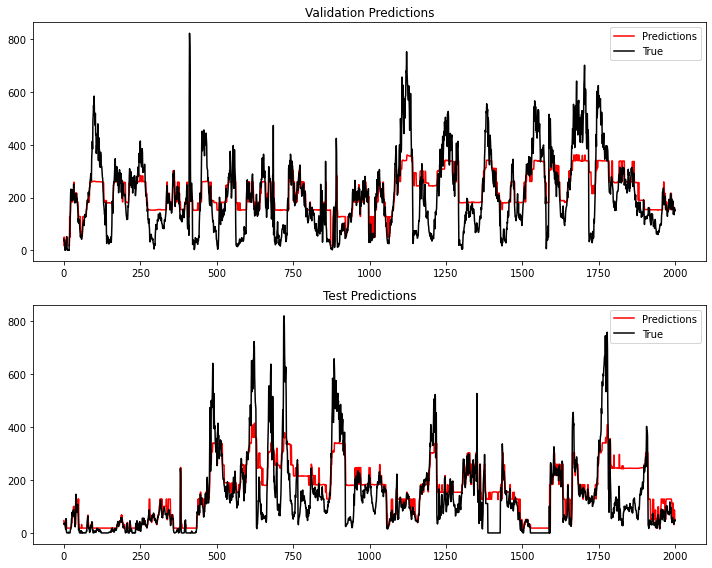

In [60]:
next_day_rec,_=model.model_summarizer(val_x, val_y[:,0], test_x, test_y[:,0], plots=True,
plot_steps=2000, feat_importance=False, feat_steps=15,feat_names= columns,horizon =144)

### Recursive with Transferred Hyp-op

In [61]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU",'learning_rate': 0.060056213534812046, 'depth': 9, 'min_data_in_leaf': 64},prediction_type = 'recursive')
model.train(train_x, train_y[:,0], val_x, val_y[:,0], multioutput= False)

0:	learn: 218.6578503	test: 247.6320621	best: 247.6320621 (0)	total: 52.3ms	remaining: 52.3s
500:	learn: 51.6893258	test: 39.7549899	best: 39.7170242 (381)	total: 21.3s	remaining: 21.2s
999:	learn: 48.7038744	test: 39.9299724	best: 39.7170242 (381)	total: 41.6s	remaining: 0us
bestTest = 39.71702419
bestIteration = 381
Shrink model to first 382 iterations.


                   MAE        RMSE        R2
Validation   45.918971   71.821149  0.681843
Test        102.999417  136.212515  0.581509


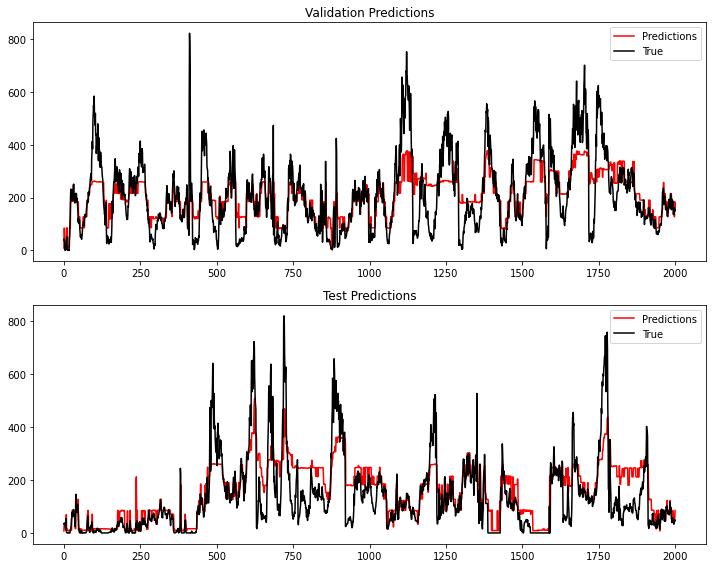

In [62]:
next_day_rec,_=model.model_summarizer(val_x, val_y[:,0], test_x, test_y[:,0], plots=True,
plot_steps=2000, feat_importance=False, feat_steps=15,feat_names= columns,horizon =144)

# Result Comparison

In [46]:
next_step_baseline = {'MAE': 91.554 , 'RMSE': 145.603, 'R2':0 }
results = [next_step_baseline,next_step_os.iloc[1,:],next_step_os_feat.iloc[1,:],next_step_os_feat_hy.iloc[1,:]]

names = ['Baseline', ' One Shot', ' One Shot Feat', ' One Shot Feat + Hyp-op']

experiment_results(names, results,title = 'Next Step Prediction')

NameError: name 'next_step_os' is not defined

In [ ]:
next_hour_baseline = {'MAE': 183.286 , 'RMSE': 263.749	, 'R2':0 }	
results = [next_hour_baseline,next_hour_os.iloc[1,:],next_hour_os_feat.iloc[1,:],next_hour_os_feat_hy.iloc[1,:],next_hour_rec.iloc[1,:]]

names = ['Baseline', ' One Shot', ' One Shot Feat', ' One Shot Feat + Hyp-op', 'Recursive']

experiment_results(names, results,title = 'Next Hour Prediction')

In [50]:
next_day_baseline = {'MAE': 510.710 , 'RMSE': 623.023	, 'R2':0 }	
results = [next_day_baseline,next_day_os.iloc[1,:],next_day_os_feat.iloc[1,:],next_day_os_feat_hy.iloc[1,:], next_day_rec.iloc[1,:]]

names = ['Baseline', ' One Shot', ' One Shot Feat', ' One Shot Feat + Hyp-op', 'Recursive']

experiment_results(names, results,title = 'Next Day Prediction')

| Metric                 | MAE        | RMSE        | R2        |
|:-----------------------|:-----------|:------------|:----------|
| Next Day Prediction    |            |             |           |
| Baseline               | 510.71     | 623.023     | -         |
| One Shot               | 149.102    | 186.475     | 0.209     |
| One Shot Feat          | 152.186    | 186.464     | 0.21      |
| One Shot Feat + Hyp-op | 152.187    | 185.838     | 0.215     |
| Recursive              | **118.38** | **148.227** | **0.504** |
